## Machine learning starts

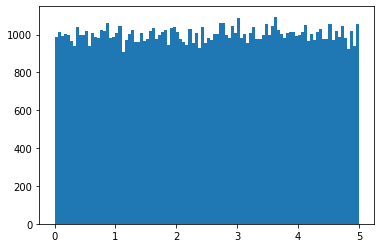

In [1]:
import numpy
import matplotlib.pyplot as plt

x = numpy.random.uniform(0.0, 5.0, 100000)

plt.hist(x, 100)
plt.show()

In [2]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

C:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: 100%|████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 95.3kB/s]
Downloading: 100%|████████████████████████████████████████████████████████████████| 3.69k/3.69k [00:00<00:00, 1.61MB/s]
Downloading: 100%|████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<?, ?B/s]
Downloading: 100%|████████████████████████████████████████████████████████████████| 90.9M/90.9M [00:18<00:00, 4.88MB/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████████████| 53.0/53.0 [00:00<?, ?B/s]
Downloading: 100%|████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<?, ?B/s]
Downl

In [3]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [4]:
@inproceedings{reimers-2019-sentence-bert,
    title = "Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks",
    author = "Reimers, Nils and Gurevych, Iryna",
    booktitle = "Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing",
    month = "11",
    year = "2019",
    publisher = "Association for Computational Linguistics",
    url = "https://arxiv.org/abs/1908.10084",
}

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (3143739751.py, line 2)

In [5]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel

MODEL_PATH = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = TFAutoModel.from_pretrained(MODEL_PATH, from_pt=True)

class SBert(tf.keras.layers.Layer):
    def __init__(self, tokenizer, model):
        super(SBert, self).__init__()
        
        self.tokenizer = tokenizer
        self.model = model
        
    def tf_encode(self, inputs):
        def encode(inputs):
            inputs = [x[0].decode("utf-8") for x in inputs.numpy()]
            outputs = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='tf')
            return outputs['input_ids'], outputs['token_type_ids'], outputs['attention_mask']
        return tf.py_function(func=encode, inp=[inputs], Tout=[tf.int32, tf.int32, tf.int32])
    
    def process(self, i, t, a):
      def __call(i, t, a):
        model_output = self.model({'input_ids': i.numpy(), 'token_type_ids': t.numpy(), 'attention_mask': a.numpy()})
        return model_output[0]
      return tf.py_function(func=__call, inp=[i, t, a], Tout=[tf.float32])

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = tf.squeeze(tf.stack(model_output), axis=0)
        input_mask_expanded = tf.cast(
            tf.broadcast_to(tf.expand_dims(attention_mask, -1), tf.shape(token_embeddings)),
            tf.float32
        )
        a = tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
        b = tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
        embeddings = a / b
        embeddings, _ = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings

    def call(self, inputs):
        input_ids, token_type_ids, attention_mask = self.tf_encode(inputs)
        input_ids.set_shape(tf.TensorShape((None, None)))
        token_type_ids.set_shape(tf.TensorShape((None, None)))
        attention_mask.set_shape(tf.TensorShape((None, None)))

        model_output = self.process(input_ids, token_type_ids, attention_mask)
        model_output[0].set_shape(tf.TensorShape((None, None, 384)))
        embeddings = self.mean_pooling(model_output, attention_mask)
        return embeddings

    
sbert = SBert(tokenizer, model)
inputs = tf.keras.layers.Input((1,), dtype=tf.string)
outputs = sbert(inputs)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [8]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel


MODEL_PATH = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = TFAutoModel.from_pretrained(MODEL_PATH, from_pt=True)


class SBert(tf.keras.layers.Layer):
    def __init__(self, tokenizer, model):
        super(SBert, self).__init__()
        
        self.tokenizer = tokenizer
        self.model = model
        
    def tf_encode(self, inputs):
        def encode(inputs):
            inputs = [x.decode("utf-8") for x in inputs.numpy()]
            outputs = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='tf')
            return outputs['input_ids'], outputs['token_type_ids'], outputs['attention_mask']
        return tf.py_function(func=encode, inp=[inputs], Tout=[tf.int32, tf.int32, tf.int32])
    
    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = tf.cast(
            tf.broadcast_to(tf.expand_dims(attention_mask, -1), tf.shape(token_embeddings)),
            tf.float32
        )
        a = tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
        b = tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
        embeddings = a / b
        embeddings, _ = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings
    def call(self, inputs):
        input_ids, token_type_ids, attention_mask = self.tf_encode(inputs)
        model_output = self.model({'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask})
        embeddings = self.mean_pooling(model_output, attention_mask)
        return embeddings
    
    
sbert = SBert(tokenizer, model)
sbert(['some text', 'more text'])

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel

MODEL_PATH = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = TFAutoModel.from_pretrained(MODEL_PATH, from_pt=True)

class SBert(tf.keras.layers.Layer):
    def __init__(self, tokenizer, model):
        super(SBert, self).__init__()
        
        self.tokenizer = tokenizer
        self.model = model
        
    def tf_encode(self, inputs):
        def encode(inputs):
            inputs = [x[0].decode("utf-8") for x in inputs.numpy()]
            outputs = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='tf')
            return outputs['input_ids'], outputs['token_type_ids'], outputs['attention_mask']
        return tf.py_function(func=encode, inp=[inputs], Tout=[tf.int32, tf.int32, tf.int32])
    
    def process(self, i, t, a):
      def __call(i, t, a):
        model_output = self.model({'input_ids': i.numpy(), 'token_type_ids': t.numpy(), 'attention_mask': a.numpy()})
        return model_output[0]
      return tf.py_function(func=__call, inp=[i, t, a], Tout=[tf.float32])

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = tf.squeeze(tf.stack(model_output), axis=0)
        input_mask_expanded = tf.cast(
            tf.broadcast_to(tf.expand_dims(attention_mask, -1), tf.shape(token_embeddings)),
            tf.float32
        )
        a = tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
        b = tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
        embeddings = a / b
        embeddings, _ = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings
    def call(self, inputs):
        input_ids, token_type_ids, attention_mask = self.tf_encode(inputs)
        model_output = self.process(input_ids, token_type_ids, attention_mask)
        embeddings = self.mean_pooling(model_output, attention_mask)
        return embeddings
    
    
sbert = SBert(tokenizer, model)
inputs = tf.keras.layers.Input((1,), dtype=tf.string)
outputs = sbert(inputs)
model = tf.keras.Model(inputs, outputs)
model(tf.constant(['some text', 'more text']))

TensorShape([2, 384]).shape

 ----------------------- 
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel


MODEL_PATH = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = TFAutoModel.from_pretrained(MODEL_PATH, from_pt=True)


class SBert(tf.keras.layers.Layer):
    def __init__(self, tokenizer, model):
        super(SBert, self).__init__()
        
        self.tokenizer = tokenizer
        self.model = model
        
    def tf_encode(self, inputs):
        def encode(inputs):
            inputs = [x.decode("utf-8") for x in inputs.numpy()]
            outputs = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='tf')
            return outputs['input_ids'], outputs['token_type_ids'], outputs['attention_mask']
        return tf.py_function(func=encode, inp=[inputs], Tout=[tf.int32, tf.int32, tf.int32])
    
    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = tf.cast(
            tf.broadcast_to(tf.expand_dims(attention_mask, -1), tf.shape(token_embeddings)),
            tf.float32
        )
        a = tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
        b = tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
        embeddings = a / b
        embeddings, _ = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings
    def call(self, inputs):
        input_ids, token_type_ids, attention_mask = self.tf_encode(inputs)
        model_output = self.model({'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask})
        embeddings = self.mean_pooling(model_output, attention_mask)
        return embeddings
    
    
sbert = SBert(tokenizer, model)
sbert(['some text', 'more text'])

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel

MODEL_PATH = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = TFAutoModel.from_pretrained(MODEL_PATH, from_pt=True)

class SBert(tf.keras.layers.Layer):
    def __init__(self, tokenizer, model):
        super(SBert, self).__init__()
        
        self.tokenizer = tokenizer
        self.model = model
        
    def tf_encode(self, inputs):
        def encode(inputs):
            inputs = [x[0].decode("utf-8") for x in inputs.numpy()]
            outputs = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='tf')
            return outputs['input_ids'], outputs['token_type_ids'], outputs['attention_mask']
        return tf.py_function(func=encode, inp=[inputs], Tout=[tf.int32, tf.int32, tf.int32])
    
    def process(self, i, t, a):
      def __call(i, t, a):
        model_output = self.model({'input_ids': i.numpy(), 'token_type_ids': t.numpy(), 'attention_mask': a.numpy()})
        return model_output[0]
      return tf.py_function(func=__call, inp=[i, t, a], Tout=[tf.float32])

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = tf.squeeze(tf.stack(model_output), axis=0)
        input_mask_expanded = tf.cast(
            tf.broadcast_to(tf.expand_dims(attention_mask, -1), tf.shape(token_embeddings)),
            tf.float32
        )
        a = tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
        b = tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
        embeddings = a / b
        embeddings, _ = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings
    def call(self, inputs):
        input_ids, token_type_ids, attention_mask = self.tf_encode(inputs)
        model_output = self.process(input_ids, token_type_ids, attention_mask)
        embeddings = self.mean_pooling(model_output, attention_mask)
        return embeddings
    
    
sbert = SBert(tokenizer, model)
inputs = tf.keras.layers.Input((1,), dtype=tf.string)
outputs = sbert(inputs)
model = tf.keras.Model(inputs, outputs)
model(tf.constant(['some text', 'more text']))

TensorShape([2, 384]).shape

 ----------------------- 
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel


MODEL_PATH = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = TFAutoModel.from_pretrained(MODEL_PATH, from_pt=True)


class SBert(tf.keras.layers.Layer):
    def __init__(self, tokenizer, model):
        super(SBert, self).__init__()
        
        self.tokenizer = tokenizer
        self.model = model
        
    def tf_encode(self, inputs):
        def encode(inputs):
            inputs = [x.decode("utf-8") for x in inputs.numpy()]
            outputs = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='tf')
            return outputs['input_ids'], outputs['token_type_ids'], outputs['attention_mask']
        return tf.py_function(func=encode, inp=[inputs], Tout=[tf.int32, tf.int32, tf.int32])
    
    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = tf.cast(
            tf.broadcast_to(tf.expand_dims(attention_mask, -1), tf.shape(token_embeddings)),
            tf.float32
        )
        a = tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
        b = tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
        embeddings = a / b
        embeddings, _ = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings
    def call(self, inputs):
        input_ids, token_type_ids, attention_mask = self.tf_encode(inputs)
        model_output = self.model({'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask})
        embeddings = self.mean_pooling(model_output, attention_mask)
        return embeddings
    
    
sbert = SBert(tokenizer, model)
sbert(['some text', 'more text'])

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel

MODEL_PATH = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = TFAutoModel.from_pretrained(MODEL_PATH, from_pt=True)

class SBert(tf.keras.layers.Layer):
    def __init__(self, tokenizer, model):
        super(SBert, self).__init__()
        
        self.tokenizer = tokenizer
        self.model = model
        
    def tf_encode(self, inputs):
        def encode(inputs):
            inputs = [x[0].decode("utf-8") for x in inputs.numpy()]
            outputs = self.tokenizer(inputs, padding=True, truncation=True, return_tensors='tf')
            return outputs['input_ids'], outputs['token_type_ids'], outputs['attention_mask']
        return tf.py_function(func=encode, inp=[inputs], Tout=[tf.int32, tf.int32, tf.int32])
    
    def process(self, i, t, a):
          def __call(i, t, a):
            model_output = self.model({'input_ids': i.numpy(), 'token_type_ids': t.numpy(), 'attention_mask': a.numpy()})
            return model_output[0]
            return tf.py_function(func=__call, inp=[i, t, a], Tout=[tf.float32])

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = tf.squeeze(tf.stack(model_output), axis=0)
        input_mask_expanded = tf.cast(
            tf.broadcast_to(tf.expand_dims(attention_mask, -1), tf.shape(token_embeddings)),
            tf.float32
        )
        a = tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
        b = tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
        embeddings = a / b
        embeddings, _ = tf.linalg.normalize(embeddings, 2, axis=1)
        return embeddings
    def call(self, inputs):
        input_ids, token_type_ids, attention_mask = self.tf_encode(inputs)
        model_output = self.process(input_ids, token_type_ids, attention_mask)
        embeddings = self.mean_pooling(model_output, attention_mask)
        return embeddings
    
    
sbert = SBert(tokenizer, model)
inputs = tf.keras.layers.Input((1,), dtype=tf.string)
outputs = sbert(inputs)
model = tf.keras.Model(inputs, outputs)
model(tf.constant(['some text', 'more text']))

TensorShape([2, 384]).shape

IndentationError: unexpected indent (1345659764.py, line 98)